In [ ]:
# -*- coding: utf-8 -*-

import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import random
import numpy as np
import os
import matplotlib.pyplot as plt


In [61]:

# ✅ 시드 고정 함수
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

In [62]:
# ✅ 데이터 불러오기 (업로드한 파일 반영)
file_path = '/content/2025_급식데이터_YOLO용_면적단위 (2).csv'
data = pd.read_csv(file_path, encoding='utf-8')


In [63]:
# 공백 제거
data.columns = data.columns.str.strip()

# 열 이름 확인 (디버깅용)
print("열 이름:", data.columns.tolist())


열 이름: ['날짜', '메뉴', '제공량(kg)', '선호도', '기온(°C)', '계절', '1학년_남', '1학년_여', '2학년_남', '2학년_여', '3학년_남', '3학년_여', '체육대회', '현장체험학습', '점심행사', '잔반량(cm^2)']


In [64]:
# ✅ 독립변수/종속변수 분리
X = data[['선호도', '기온(°C)', '계절',
          '1학년_남', '1학년_여',
          '2학년_남', '2학년_여',
          '3학년_남', '3학년_여',
          '체육대회', '현장체험학습', '점심행사',
          '제공량(kg)']]

y = data[['잔반량(cm^2)']]

In [65]:
# ✅ 범주형 변수 원핫 인코딩
X_encoded = pd.get_dummies(X, columns=['계절', '점심행사'])



In [66]:
# ✅ 수치형 변수 정규화
scaler = StandardScaler()
num_cols = ['선호도', '기온(°C)', '1학년_남', '1학년_여', '2학년_남', '2학년_여', '3학년_남', '3학년_여', '제공량(kg)']
X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])



In [67]:
# ✅ 데이터 분리 (train: 70%, val: 10%, test: 20%)
X_temp, X_test, y_temp, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# ✅ 모델 정의
input_layer = tf.keras.layers.Input(shape=(X_encoded.shape[1],))
x = tf.keras.layers.Dense(32, activation='relu')(input_layer)
x = tf.keras.layers.Dense(16, activation='relu')(x)
output_layer = tf.keras.layers.Dense(1)(x)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# ✅ 모델 컴파일
model.compile(optimizer='adam', loss='mse')



Train: 679, Val: 97, Test: 194


In [71]:
# ✅ 학습
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)



Epoch 1/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 180.3560 - val_loss: 625.5031
Epoch 2/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 179.7413 - val_loss: 624.6451
Epoch 3/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 179.5168 - val_loss: 624.7567
Epoch 4/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 178.8124 - val_loss: 623.8199
Epoch 5/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 178.5371 - val_loss: 622.0427
Epoch 6/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 177.7113 - val_loss: 620.8483
Epoch 7/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 177.5564 - val_loss: 620.2776
Epoch 8/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 176.9974 - val_loss: 620.1190
Epoch 9/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 176.5200 - val_loss: 620.1099
Epoch 10/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 175.5845 - val_loss: 619.1124
Epoch 11/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 175.4761 - val_loss: 618.2207
Epoch 12/500
43/43 

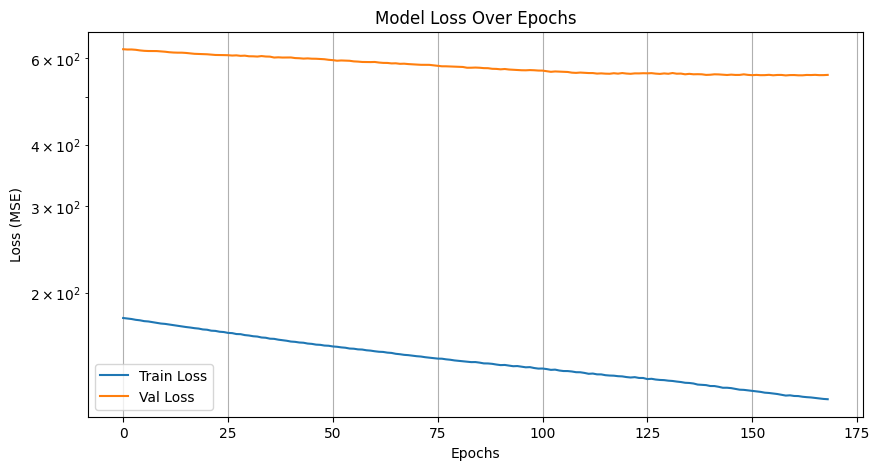

In [72]:
# ✅ 학습 결과 시각화 (로그 스케일)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
# ✅ 테스트셋 예측 확인
print("예측 결과 (테스트셋 일부):")
print(model.predict(X_test[:5]))
print("실제 잔반량:")
print(y_test[:5].values)

# ✅ 새 데이터 예측 예시
new_input = pd.DataFrame([{
    '제공량(kg)': 6.33,
    '선호도': 4,
    '기온(°C)': 12.9,
    '계절': '봄',
    '1학년_남': 28,
    '1학년_여': 21,
    '2학년_남': 29,
    '2학년_여': 28,
    '3학년_남': 27,
    '3학년_여': 30,
    '체육대회': 0,
    '현장체험학습': 0,
    '점심행사': 1
}])

# 새 데이터 전처리
new_encoded = pd.get_dummies(new_input, columns=['계절', '점심행사'])
new_encoded = new_encoded.reindex(columns=X_encoded.columns, fill_value=0)
new_encoded[num_cols] = scaler.transform(new_encoded[num_cols])

# 예측
predicted_leftover = model.predict(new_encoded)
print("예측된 잔반량:", predicted_leftover[0][0])

# ✅ 모델 저장 및 로드
model.save("leftover_prediction_model.keras")
reconstructed_model = keras.models.load_model("leftover_prediction_model.keras")

예측 결과 (테스트셋 일부):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[[ 893.3131 ]
 [2308.3916 ]
 [ 511.40686]
 [1667.95   ]
 [ 940.87256]]
실제 잔반량:
[[ 885.]
 [2310.]
 [ 519.]
 [1671.]
 [ 927.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
예측된 잔반량: 1258.5697
